# A Plot of $k_{obs}$ vs. $\%H_2SO_4$ or $H_0$

This code will create the figure 2 in the discussion that plots $k_{obs}$ vs. $\% H_2SO_4$ and $\log{k_{obs}}$ vs $0.62H_0$ 

In [1]:
##############################################################
### Set up libraries and global variables
##############################################################
 
import interpolators   ### import the following functions from local library
# interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byMoleFraction()
# interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
# interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()

import pandas as pd
pd.options.mode.chained_assignment = None    # no warning message and no exception is raised

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.stats import linregress
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar


from statsmodels.nonparametric.smoothers_lowess import lowess     # A function for interpolating a plot using the locally weighed scatterplot smoothing method. Returns smoothed x,y points
from scipy.interpolate import CubicSpline                         # A function for interpolating a plot using the cubic spline method. Returns an interpolation function.
from scipy.interpolate import interp1d                            # A function for interpolating a plot using the connect-the-dots method. Returns an interpolation function.
from scipy.interpolate import make_smoothing_spline               # A function for interpolating a plot using a Bspline algorithm. Returns an interpolation function.

from matplotlib.patches import PathPatch
from matplotlib.path import Path


#github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_30/data/"
github_location = "./data/"
github_H0_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_08/data/H0_data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_styles = "./styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

molwtH2SO4 = 98.08
molwtH2O = 18.0
densityH2SO4 = 1.83
densityH2O = 1.000


In [3]:
##############################################################
### DATAFRAME for ESTER HYDROLYSIS KINETIC DATA
##############################################################

##############################################################
### Import the data and perform calculations
##############################################################

Data_File_Name = "Yates_Table1.csv"

Filename = github_location + Data_File_Name

df = pd.read_csv(Filename, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="Substituent", 
                 comment = "#") 
#display(df)

df1 = (df.loc[df['Ester'] == 'MeOAc'])   ### Select only the MeOAc data
df1 = (df1.loc[0:11])   ### Select only the given lines

##############################################################
### Perform calculations
##############################################################

df1["kobs"] = df1["kobs"] * 1E-2 * 60    # convert from 10^-2 min^-1 to s^-1
df1["kobs"] = df1["kobs"]

PercentH2SO4 = df1["%H2SO4"]
molesH2SO4 = PercentH2SO4 / molwtH2SO4
PercentH2O = 100 - PercentH2SO4
molesH2O = PercentH2O / molwtH2O
total_moles = molesH2SO4 + molesH2O
mole_fraction_H2SO4 = molesH2SO4 / total_moles

df1["X_H2SO4"] = mole_fraction_H2SO4

interpolatorH0 = interpolators.MakeInterpolationFunctionForH0inH2SO4byPercentWt()
df1["H0"] = interpolatorH0(PercentH2SO4)

m = 0.62
df1["HS"] = df1["H0"] * m

df1["log_k_obs"] = np.log10(df1["kobs"])

interpolator_aH2O = interpolators.MakeInterpolationFunctionForH2OActivityinH2SO4byPercentWt()
df1["aH2O"] = interpolator_aH2O(PercentH2SO4)

interpolator_density = interpolators.MakeInterpolationFunctionForDensityofH2SO4byPercentWt()
density = interpolator_density(PercentH2SO4)

volume = 1000
gramsH2O = volume * density * PercentH2O/100
molesH2O = gramsH2O / molwtH2O    # per liter
df1["density"] = density
df1["Molar_H2O"] = molesH2O
X_H2O = 1-df1["X_H2SO4"]          # mole fraction H2O in H2SO4
gamma_H2O = df1["aH2O"]/(X_H2O)   # activity coefficient for H2O in H2SO4
df1["Molar_aH2O"] = gamma_H2O * df1["Molar_H2O"]

#df1 = df1.iloc[:-3] # remove last three rows (the missing data) 
display(df1)

,Ester,%H2SO4,kobs,X_H2SO4,H0,HS,log_k_obs,aH2O,density,Molar_H2O,Molar_aH2O
0,MeOAc,14.1,0.900,0.029243,-0.602729,-0.373692,-0.045757,0.929672,1.095402,52.274995,50.062576
1,MeOAc,20.7,1.566,0.045716,-1.037527,-0.643266,0.194792,0.873362,1.145275,50.455747,46.177140
2,MeOAc,28.3,2.532,0.067544,-1.511469,-0.937111,0.403464,0.778090,1.205483,48.018423,40.069105
3,MeOAc,34.8,3.846,0.089215,-1.999334,-1.239587,0.585009,0.668753,1.258437,45.583388,33.470084
4,MeOAc,40.4,4.884,0.110638,-2.418862,-1.499694,0.688776,0.556825,1.306328,43.253973,27.081094
5,MeOAc,45.4,6.240,0.132397,-2.793058,-1.731696,0.795185,0.449579,1.351447,40.993888,21.242417
6,MeOAc,50.2,6.840,0.156117,-3.233884,-2.005008,0.835056,0.346582,1.397135,38.654075,15.875174
7,MeOAc,55.2,7.980,0.184424,-3.781791,-2.344711,0.902003,0.246168,1.447514,36.027011,10.874154
8,MeOAc,60.4,8.280,0.218701,-4.396537,-2.725853,0.918030,0.156455,1.502772,33.060974,6.620468
9,MeOAc,65.2,7.140,0.255866,-5.004720,-3.102926,0.853698,0.091126,1.555573,30.074416,3.682898


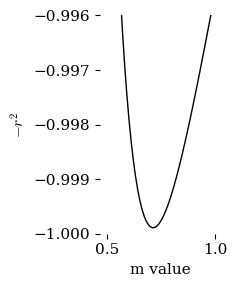

The optimal value for r is 0.712 for rsq = -0.99989


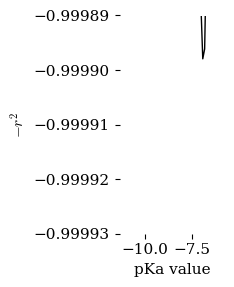

The optimal value for r is 45.361 for rsq = -0.09405
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.9999087475788362
        x: [ 6.955e-01 -7.052e+00]
      nit: 19
      jac: [ 4.262e-06  2.980e-08]
 hess_inv: [[ 1.258e+01 -1.907e+02]
            [-1.907e+02  5.525e+03]]
     nfev: 69
     njev: 23
The optimal value for m is -7.052 and for pka is 0.695 for rsq = 0.99982


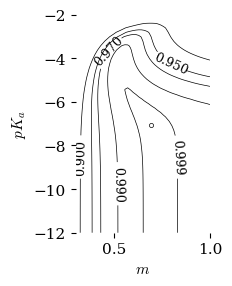

In [ ]:
###################################################
### CURVE FIT FOR PARAMETERS
###################################################

# Try to curve fit for m, pKa and maybe n


def RSQ_function(m):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    pKa = -7.5
    Ka=10**-pKa
    h_0 = 10**-df1["H0"]
    x = np.log10(df1["Molar_aH2O"]) 
#    y = df1["log_k_obs"]+ m * df1["H0"]
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)

def RSQ_function2(pKa):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    m = 0.68
    h_0 = 10**-df1["H0"]
    Ka = 10**-pKa
    x = np.log10(df1["Molar_aH2O"]) 
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)


##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-r^2$", 
       xlabel=r"m value",
#       xlim=[0.3,1.0],                  
       ylim=[-1,-0.996]
)

rsq_range=[]
r_range = np.arange(0.5,1,0.01)
for r in r_range:
    rsq = RSQ_function(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range)

fig.savefig("fig20.pdf")   # use this to save the figure in PDF format
plt.show()

##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")



##########################################################
### Plot the value of -RSQ as the value of r is varied ###
##################################################

style_file = "tufte.mplstyle"
#style_file = "S2_classic2.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   
ax.set(ylabel=r"$-r^2$", 
       xlabel=r"pKa value",
#       xlim=[0.3,1.0],                  
       ylim=[-0.99993,-0.99989]
         )


rsq_range=[]
r_range = np.arange(-11,-6.0,0.1)
for r in r_range:
    rsq = RSQ_function2(r)
    rsq_range.append(rsq)
    
ax.plot(r_range,rsq_range)

#fig.savefig("plots/plot.pdf")   # use this to save the figure in PDF format
plt.show()

##################################################
### Determine optimal r value to minimize -RSQ ###
##################################################

r_opt = minimize_scalar(RSQ_function2)
print(f"The optimal value for r is {r_opt['x']:0.3f} for rsq = {r_opt['fun']:0.5f}")


### CONTOUR PLOT


################################################################################
### Define a function to be minimized
################################################################################


def RSQ_function3(params):    # returns the RSQ for linefits using the given Yukawa-Tsuno r factor
    m, pKa = params
    h_0 = 10**-df1["H0"]
    Ka = 10**-pKa
    x = np.log10(df1["Molar_aH2O"]) 
    y = df1["log_k_obs"]- np.log10(h_0**m/(Ka**m + h_0**m))
    linfit = linregress(x,y)
    return -(linfit.rvalue**2)


################################################################################
### optimize the param list to obtain the minimum result of the function.
################################################################################

r_opt = minimize(RSQ_function3, [0.7,-8])
#print(r_opt)
r_minus, r_plus = r_opt['x']
print(r_opt)
print(f"The optimal value for m is {r_plus:0.3f} and for pka is {r_minus:0.3f} for rsq = {r_opt['fun']**2:0.5f}")

################################################################################
### Create a plot object
################################################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3))  
ax.margins(x=.07, y=.07, tight=True)

ax.set(
#    title="Yukawa-Tsuno Plot",       
          ylabel=r"$pK_a$", 
          xlabel=r"$m$",                
          xlim=[0.3,1.0],                  
          ylim=[-12,-2]
         )

################################################################################
### use the function to caluate the RSQ for the line fit at every value of r+ and r-
## and then plot the result as a contour plot
################################################################################

mlist = np.linspace(0.3, 1.0, 50)
pKalist = np.linspace(-12.0, -2.0, 50)         #  vary r_plus and r_minus from -1.1 to +1.1

### This loop cycles through all the pairings of r+ and r- and calculates RSQ for each case
l1 = []                                
for pKa in pKalist:
    l2 = []
    for m in mlist:
        rsq = RSQ_function3([m,pKa])    
        l2.append(rsq)
    l1.append(l2)
l3 = np.matrix(l1)
#print(l3)

### Set up contour plot
X, Y = np.meshgrid(mlist, pKalist)
#levels = [0.95,0.96,0.97, 0.98, 0.99, 0.995, 0.999, 0.9998]
#levels = [0.90,0.95,0.97, 0.98, 0.995, 0.999, 0.9998]
levels = [0.90,0.95,0.97, 0.99, 0.999]

### plot lines along the x and y axes
ax.hlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)
ax.vlines(0,-1,1, color = "lightgray", zorder = 1, linewidths=0.5)

### Plot the contour lines as thick white lines 
#ax.contour(X, Y, -l3, levels, colors = "white", linewidths=3, zorder = 2)

### Create contour plot as 'CS' and then plot 'CS' with lables
CS = ax.contour(X, Y, -l3, levels, colors = "black", linewidths=0.5, zorder = 2)
ax.clabel(CS, inline=True, fontsize=9)

### Plot the true minimum value as a point
ax.plot(r_minus,r_plus,"o", color="white", markeredgecolor = "black", markeredgewidth = 0.5, markersize = 3)
#ax.plot(pKa,m,"o", color="black", markersize = 2)

#ax.hlines(-9.5,0.3,1, color ="red", linewidths =0.5, zorder=0)
#ax.vlines(0.73,-12,-2, color ="red", linewidths =0.5, zorder=0)


################################################################################
### Output the plot to a pdf file and show it in this notebook.
################################################################################


fig.savefig("plot/01_F25_fig23.pdf")   # use this to save the figure in PDF format

plt.show()

#print(mlist)
#print(pKalist)





LinregressResult(slope=1.8963481740099637, intercept=1.2120635737799619, rvalue=0.9999543634110064, pvalue=1.5587749293646714e-21, stderr=0.005729339122485215, intercept_stderr=0.007003722290431278)


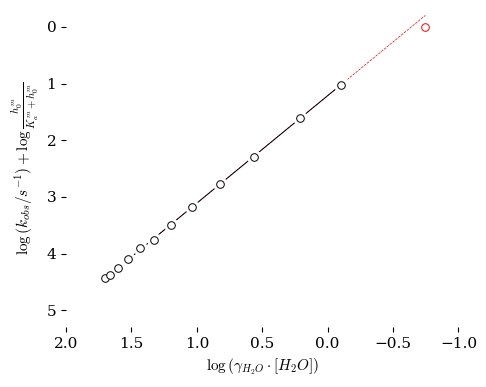

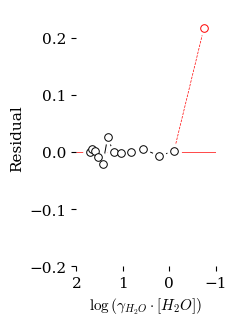

In [ ]:
###################################################
### MAKE PLOT
###################################################

pKa = -7.05
#pKa = -4.95

Ka = 10**-pKa

h_0 = 10**-df1["H0"]

m = 0.695
#m = 0.54

###################################################
### Select the data for ESTER HYDROLYSIS
###################################################

#x = np.log10(df1["aH2O"])
x = np.log10(df1["Molar_aH2O"])

term1 =df1["log_k_obs"]
term2 = np.log10(h_0**m/(Ka**m + h_0**m))

#y = df1["log_k_obs"]
#y = df1["log_k_obs"]-np.log10(h_0**m/(Ka**m + h_0**m))
y = term1 - term2
#y = df1["log_k_obs"] + m * df1["H0"]


###################################################
### Create figure for plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
#ax2 = ax.twinx()

###################################################
### Set up labels
###################################################

#x_label = "$\%wt {H_2SO_4}$"
#x_label = "$\log{a_{H_2O}}$"
x_label = "$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

#y_label = "$\log{(k_{obs} / {s}^{-1})} + mH_0$"
y_label = "$\log{(k_{obs} / {s}^{-1})} + \log\\frac{h_0^m}{K_a^m+h_0^m}$"

###################################################
### RATE vs ACIDITY Plot
###################################################

if True:                  # Set up axes for main plot
    ax.set(ylabel=y_label, xlabel=x_label,
           xlim=[2,-1],
           ylim=[5.3,-0.3]
           )

if True:                       # Data points for kobs vs Acidity
    ax.scatter(x, y, 
              marker = "o", s = 30, 
              color = "white", edgecolors = "black", linewidths=0.7, 
              zorder = 3)
    ax.scatter(x, y,           # White circle behind each data point 
              marker = "o", s = 90, 
              color = "white", 
              zorder = 2)
    
### Plot the components of the line to see their contributions
#ax.plot(x, term1, "-", color = "green", linewidth=0.7, zorder = 1)
#ax.plot(x, term2, "-", color = "blue", linewidth=0.7, zorder = 1)


a = linregress(x,y)
print(a)
y_line = a.slope * x + a.intercept

ax.plot(x, y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 1)

if True:     # Add the residual for the highest conc point where the line is for the line fit without that point
        xpair = [-0.103260, -0.747457]
        ypair = [0.994620, -0.001964]
        xline = x
        xline[12] = -0.747457
        y_line = a.slope * xline + a.intercept
        ax.plot(xline, y_line,    # Plot line fit
                "--", color = "red", linewidth=0.5, 
                zorder = 0)
        ax.scatter(xpair, ypair,           # White circle behind each data point 
                  marker = "o", s = 90, 
                  color = "white", 
                  zorder = 0)
#        ylinepair = a.slope * xpair + a.intercept
        ax.scatter(xpair, ypair, 
                  marker = "o", s = 30, 
                  color = "white", edgecolors = "red", linewidths=0.7, 
                  zorder = 0)







plt.savefig("plots/01_F23_fig24.pdf")
plt.show()

[-0.103260, -0.747457], 

###################################################
### Create figure for RESIDUAL plot
###################################################

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.5,3.4))  

###################################################
### Set up labels
###################################################

#x_label = "$\log{a_{H_2O}}$"
x_label = "$\log{(\gamma_{H_2O} \cdot [{H_2O}])}$"

y_label = "Residual"

###################################################
### Plot the residuals
###################################################

ax.set(ylabel=y_label, xlabel=x_label,
           xlim=[2,-1],
           ylim=[-.2,.25]
        )

ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "white", linewidth=3, 
        zorder = 1)
ax.plot(x, y-y_line,    # Plot line fit
        "-", color = "black", linewidth=0.7, 
        zorder = 1)

ax.scatter(x, y-y_line,           # White circle behind each data point 
          marker = "o", s = 90, 
          color = "white", 
          zorder = 2)
ax.scatter(x, y-y_line, 
          marker = "o", s = 30, 
          color = "white", edgecolors = "black", linewidths=0.7, 
          zorder = 2)

#ax.hlines(0,np.min(x),np.max(x), color ="red", linewidths =0.5, zorder=0)
ax.hlines(0,-1,2, color ="red", linewidths =0.5, zorder=0)

if True:     # Add the residual for the highest conc point where the line is for the line fit without that point
        xpair = [-0.103260, -0.747457]
        ypair = [0.002128, 0.21734]
        ax.plot(xpair, ypair,    # Plot line fit
                "--", color = "red", linewidth=0.5, 
                zorder = 0)
        ax.scatter(xpair, ypair,           # White circle behind each data point 
                  marker = "o", s = 90, 
                  color = "white", 
                  zorder = 0)
        ax.scatter(xpair, ypair, 
                  marker = "o", s = 30, 
                  color = "white", edgecolors = "red", linewidths=0.7, 
                  zorder = 0)

plt.savefig("plots/01_F24_fig24r.pdf")
plt.show()

#print(x, y-y_line)

In [ ]:
#slope=1.881094572293779, intercept=1.1867347976784357,

-0.001964-(1.8811*-0.747457 + 1.186734)
x,ydiff
-0.7474,0.21734

x,y
-0.747457,-0.001964

[-0.103260, -0.747457], [0.994620, -0.001964]   data
[-0.103260, -0.747457], [0.002128, 0.21734] diff

(-0.747457, -0.001964)